In [29]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

import requests

In [30]:
# color styling for heatmaps
bobmap = sns.diverging_palette(
        #127, 12,    # HUSL coordinates, get the H: http://www.hsluv.org/ (0-359)
        260, 12,    # HUSL coordinates, get the H: http://www.hsluv.org/ (0-359)
        s = 99,     # saturation (0 - 99)
        l = 50,     # lightness (0 - 99)
        center = "light",
        as_cmap = True,
    )

In [31]:
def calculate_delta(serieslike):
    
    serieslike = serieslike.astype("float64")
    
    returnlist = []
    prev = 0 # no need, but
    for i, elem in enumerate(serieslike):
        if i == 0:
            returnlist.append(elem)
            prev = elem
        else:
            returnlist.append(elem - prev)
            prev = elem
    
    return returnlist

In [32]:
# downloading the latest Protezione Civile data release
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
req = requests.get(url, allow_redirects=False)
with open("dpc-covid19-ita-andamento-nazionale.csv", "wb") as o:
    o.write(req.content)

# prepping the table

df = pd.read_csv("dpc-covid19-ita-andamento-nazionale.csv", index_col=0)
df = df[df.columns[:-2]] # stripping away the notes
df = df.drop("stato", axis=1) # all ITA cases

In [33]:
# making a slew of new columns
# cooked data is indicated with "*"
df["deceduti giornalieri*"] = calculate_delta(df["deceduti"])
df["tamponi giornalieri*"] = calculate_delta(df["tamponi"])
df["variazione isolamento domiciliare*"] = calculate_delta(df["isolamento_domiciliare"])
df["variazione terapia intensiva*"] = calculate_delta(df["terapia_intensiva"])
df["variazione ricoverati con sintomi*"] = calculate_delta(df["ricoverati_con_sintomi"])
df["variazione isolamento domiciliare*"] = calculate_delta(df["isolamento_domiciliare"])

df["ratio (positivi giornalieri / casi)*"] = list(df["nuovi_positivi"] / df["tamponi giornalieri*"])
df["nuovi positivi normalizzati*"] = df["ratio (positivi giornalieri / casi)*"] * 100

In [34]:
# dropping unwanted columns
remove = [
    "deceduti",
    "isolamento_domiciliare",
    "dimessi_guariti",
    "tamponi",
    "totale_casi",
    "totale_positivi",
    "ratio (positivi giornalieri / casi)*"
]
newcols = [x for x in df.columns if x not in remove]


# custom order
newcols = [
    'variazione terapia intensiva*',
    'variazione ricoverati con sintomi*',
    'variazione_totale_positivi',
    'nuovi_positivi',
    'deceduti giornalieri*',
    'variazione isolamento domiciliare*',
    'tamponi giornalieri*',
    'terapia_intensiva',
     'totale_ospedalizzati',
     'ricoverati_con_sintomi',
 ]

In [40]:
def draw_bigmap(
    data, columns, 
    skipdays=4, xsize=8, ysize=14, lastdays=None,
    metric="euclidean", figsize=(10,10),
    annot=False, fmt="g", annot_kws={"size":15}, center=0,    
):
    
    data = data[columns].copy()
    
    if lastdays is not None:
        data = data[-lastdays:]
    
    # heatmap plot
    # ------------
    if annot is False:
        clus = sns.clustermap(
            data.T, z_score=0, cmap=bobmap, col_cluster=False, row_cluster=False,
            xticklabels=True, metric=metric, figsize=figsize,
            center=center,
        )
    else:
        clus = sns.clustermap(
            data.T, cmap=bobmap, col_cluster=False, row_cluster=False,
            xticklabels=True, metric=metric, figsize=figsize,
            annot=annot, fmt=fmt, annot_kws=annot_kws, center=center,
        )
    
    clus.ax_heatmap.set_xticklabels(
        clus.ax_heatmap.get_xmajorticklabels(), fontsize = xsize
    )
    
    # setting the density of xlabels (<skipdays>)
    # -------------------------------------------
    for i, label in enumerate(clus.ax_heatmap.xaxis.get_ticklabels()):
        if i % skipdays != 0:
            label.set_visible(False)
        else:
            label.set_visible(True)
            
    clus.ax_heatmap.set_yticklabels(
        clus.ax_heatmap.get_ymajorticklabels(), fontsize = ysize
    )

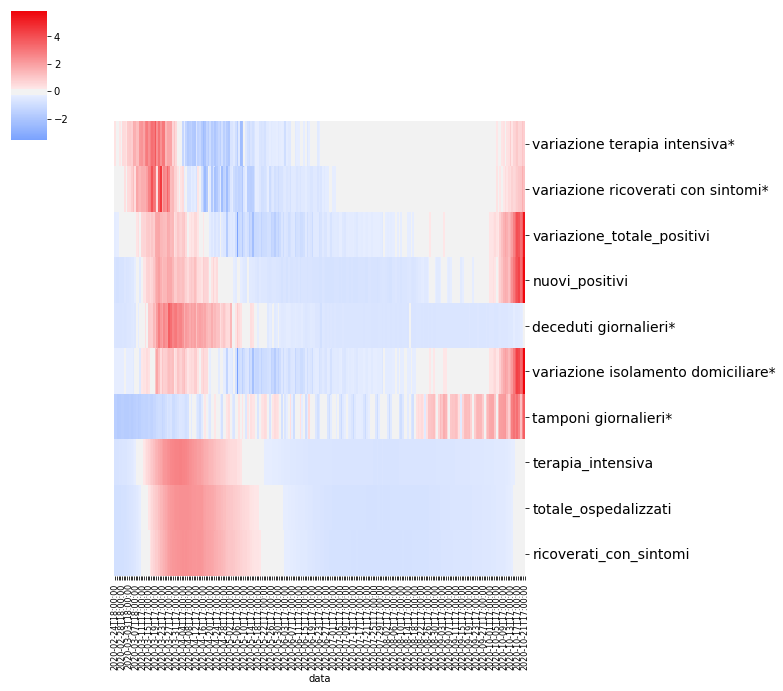

In [36]:
draw_bigmap(df, newcols)

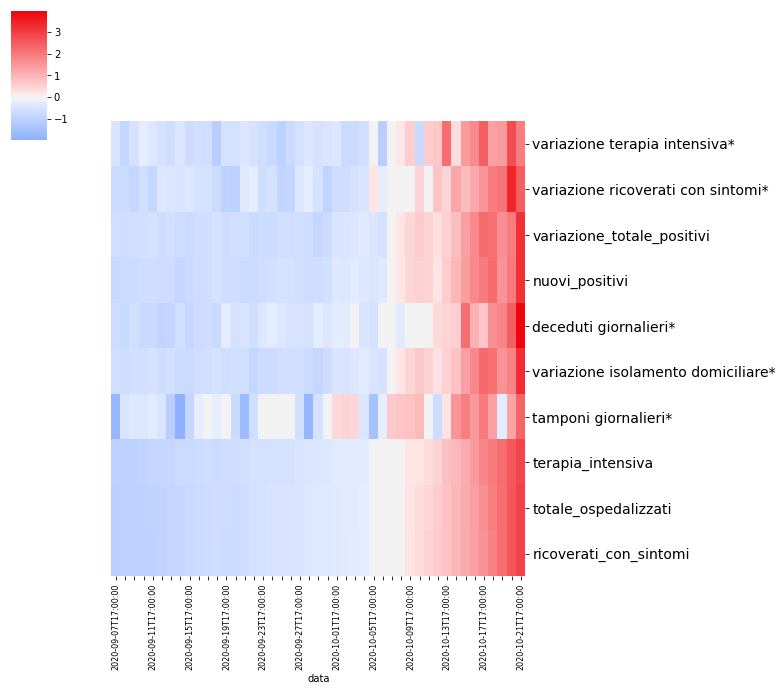

In [37]:
draw_bigmap(df, newcols, lastdays=45)

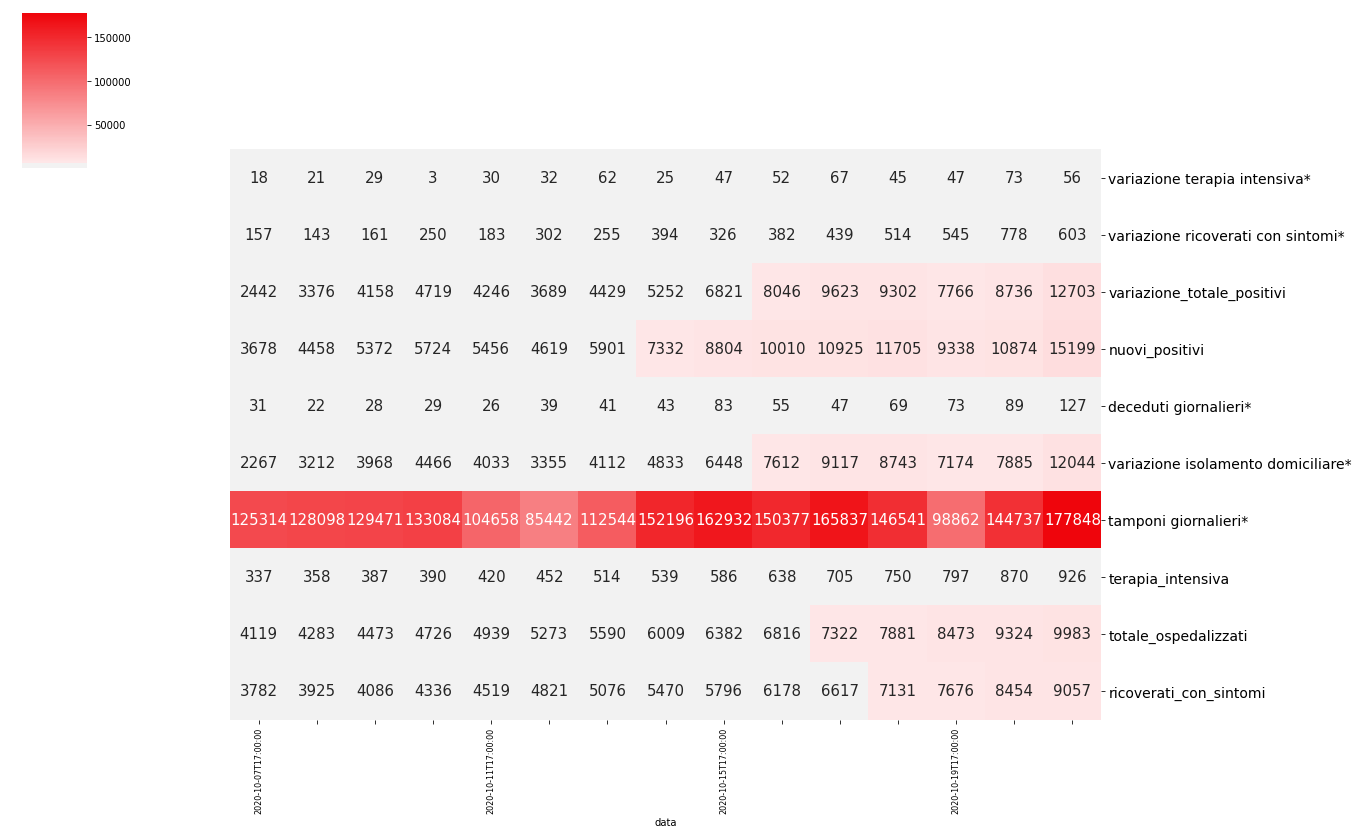

In [43]:
draw_bigmap(df, newcols, lastdays=15, annot=True, figsize=(18,12))

In [106]:
# line plots
def draw_lineplot(data, cols_list, title="", xlabel="", ylabel="", figsize=(6,4),
                  xlim=False, ylim=False, lastdays=None, dayrange=None,
                  
                  greenline=False, green_style="dashed", green_label="no variation",
                  orangeline=False, orange_height=250,
                  orange_style="dashed", orange_label="threshold",
                 ):
    
    """
    each cols_list element needs to be a valid data table header
    
    params
    ======
    dayrange: <tuple>; dayrange=(10,200)
    """
    
    
    
    if lastdays is not None and dayrange is None:
        data = data[-lastdays:]
    
    if dayrange is not None and lastdays is None:
        minday, maxday = dayrange
        #data = data[minday:maxday]
        
    if lastdays is not None and dayrange is not None:
        print("dayrange or lastdays: choose one")
        return
        
    TOTAL_DAYS = len(data)
    
    # drawing
    # -------
    plt.figure(figsize=figsize)
    for col in cols_list:
        y = list(data[col])
        x = list(range(len(y)))

        plt.plot(x, y)
        
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    
    if greenline:
        plt.hlines(0, 0, TOTAL_DAYS,
                   colors="green", label=green_label, linestyles=green_style
                  )
    if orangeline:
        plt.hlines(orange_height, 0, TOTAL_DAYS,
                   colors="orange", label=green_label, linestyles=green_style
                  )
    
    if dayrange:
        plt.xlim(minday, maxday)

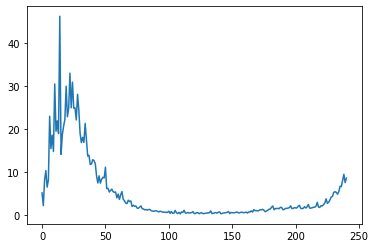

In [107]:
draw_lineplot(df, ["nuovi positivi normalizzati*"])

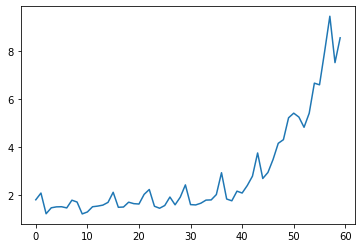

In [103]:
draw_lineplot(df, ["nuovi positivi normalizzati*"], lastdays=60)

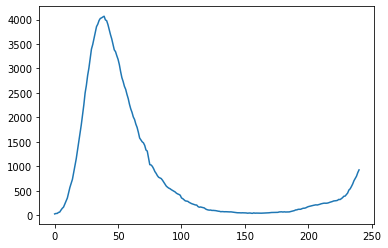

In [104]:
draw_lineplot(df, ["terapia_intensiva"])

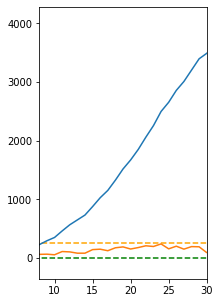

In [110]:
elems = ["terapia_intensiva", "variazione terapia intensiva*"]
WINDOW = 22 # 25 on 21/10/2020

# 8 is where roughly 250 people are in intensive care at the beginning of dataset
draw_lineplot(df, elems, greenline=True, orangeline=True, orange_height=250,
              dayrange=(8, WINDOW+8), figsize=(3,5))

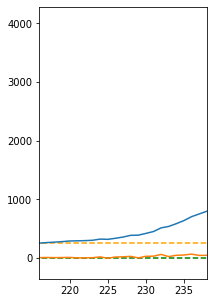

In [111]:
CARE_250 = 216 # where roughly 250 other people are in intensive care
dayrange = (CARE_250, CARE_250 + WINDOW)

elems = ["terapia_intensiva", "variazione terapia intensiva*"]

# 8 is where roughly 250 people are in intensive care at the beginning of dataset
draw_lineplot(df, elems, greenline=True, orangeline=True, orange_height=250,
              dayrange=dayrange, figsize=(3,5))

In [113]:
# custom order
newcols2 = [
    'variazione terapia intensiva*',
    'variazione isolamento domiciliare*',
    'variazione_totale_positivi',

    'deceduti giornalieri*',

    'terapia_intensiva',
    'totale_ospedalizzati',
    'ricoverati_con_sintomi',
    'nuovi positivi normalizzati*',
    

 ]

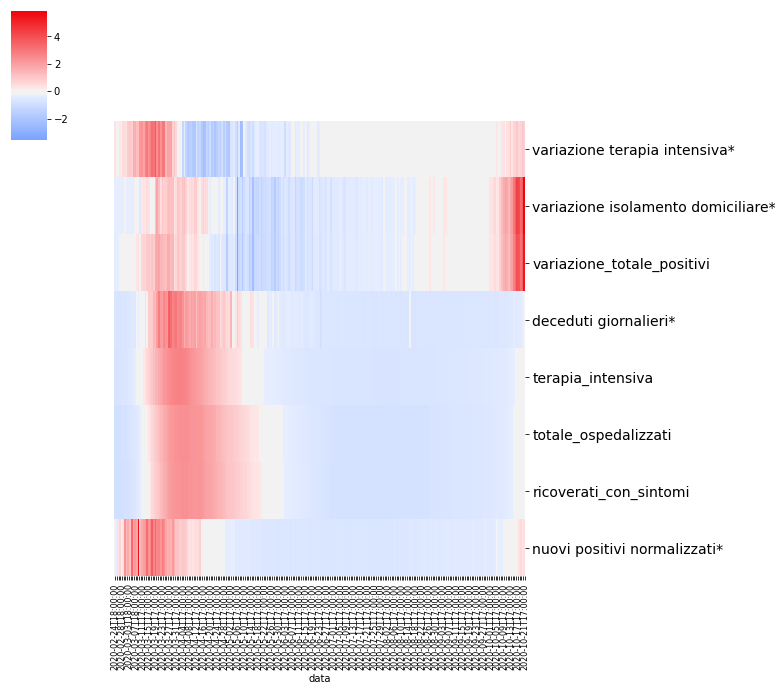

In [114]:
draw_bigmap(df, newcols2)